In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from transformers import logging
logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *

from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [3]:
from models import *

In [4]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")
translate_back=pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_all.csv")
vc2 = train_df[label_column].value_counts()

In [6]:
vc2

Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten    970
Medische apparatuur, farmaceutische artikelen en artikelen voor lichaamsverzorging                                                                 970
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen                                                                               970
Vervoersdiensten (uitg. vervoer van afval)                                                                                                         921
Diensten voor onderwijs en opleiding                                                                                                               841
Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur                                                            816
Overige gemeenschaps-,  sociale en persoonlijke diensten                                      

In [7]:
down_sample_vc = vc2[vc2.values <300]
train_df = train_df[train_df[label_column].isin(down_sample_vc.index)]
test_df=test_df[test_df[label_column].isin(down_sample_vc.index)]
translate_back=translate_back[translate_back[label_column].isin(down_sample_vc.index)]

In [8]:
value_counts=train_df[label_column].value_counts()

In [9]:
value_counts

Ondersteunende en aanvullende vervoersdiensten; reisbureaudiensten                                   227
Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten                      214
Chemische producten                                                                                  167
Muziekinstrumenten, sportartikelen, spelletjes, speelgoed, handwerk, kunstartikelen en toebehoren    153
Installatiediensten (uitgezonderd software)                                                          139
Openbare voorzieningen                                                                               108
Landbouwmachines                                                                                      90
Mijnbouw, basismetalen en aanverwante producten                                                       33
Machines voor de mijnbouw, steengroeven en voor de bouw                                               29
Name: afdeling, dtype: int64

In [10]:
all_df=pd.concat([train_df,test_df])

In [11]:
running_device = torch.device("cuda")

In [12]:
prd = ProcessData(all_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
_,_,_, label_encoder, onehot = prd.process()

After removing duplicate sentence: 1430
After drop cpv with low observations we have : 1430
The num of class is  9
The number of total data is:  1430
Total number of test data is:  270
Total number of train data is:  1153


In [13]:
model_runner = RunModel(running_device)
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 3, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(train_df)
insuf_ds_list = list(insuf_ds_dict.values())

Init new bert


Getting bert hidden states from layer: 3: 100%|██████████| 29/29 [00:00<00:00, 82.24it/s]


In [14]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [15]:
tbk_acc,gan_acc,hybrid_acc = [],[],[]
tbk_f1,gan_f1,hybrid_f1 = [],[],[]
tbk_recall,gan_recall,hybrid_recall = [],[],[]
tbk_precision,gan_precision,hybrid_precision = [],[],[]
tbk_all,gan_all,hybrid_all = [],[],[]
for i in range(1,11):
  sampled_df=translate_back.groupby(label_column, sort=False).sample(frac=float(i/20))
  sub_sample=sampled_df.groupby(label_column, sort=False).sample(frac=float(1/2))
  aug_limits = decide_aug_labels(False, None, value_counts,0.2*i)
  augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
  half_augmented_ds_lists=[]
  for dataset in augmented_ds_lists:
      evens = list(range(1, len(dataset), 2))
      subdataset = torch.utils.data.Subset(dataset, evens)
      half_augmented_ds_lists.append(subdataset)
  tbk_aug_dataset = cd.create(sampled_df)
  sub_tbk_aug=cd.create(sub_sample)
  tbk_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+[tbk_aug_dataset])
  print(len(tbk_aug_train))
  gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)
  print(len(gan_aug_train))
  hybrid_train = torch.utils.data.ConcatDataset(insuf_ds_list+half_augmented_ds_lists+[sub_tbk_aug])
  print(len(hybrid_train))
  tbk_aug_dl = DataLoader(tbk_aug_train, shuffle=True, batch_size=40)

  gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=40)

  hybrid_dl = DataLoader(hybrid_train, shuffle=True, batch_size=40)

  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=1e-5, n_epochs=7)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  tbk_acc.append(acc)
  tbk_f1.append(f1)
  tbk_recall.append(recall)
  tbk_precision.append(precision)
  tbk_all.append(label_f1)

  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=1e-5, n_epochs=7)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  gan_acc.append(acc)
  gan_f1.append(f1)
  gan_recall.append(recall)
  gan_precision.append(precision)
  gan_all.append(label_f1)
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(hybrid_dl, test_dl, classifier, lr=1e-5, n_epochs=7)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

  hybrid_acc.append(acc)
  hybrid_f1.append(f1)
  hybrid_recall.append(recall)
  hybrid_precision.append(precision)
  hybrid_all.append(label_f1)


We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 117/117 [00:01<00:00, 77.97it/s]


1393
1380
1387


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


0 train loss:  2.17700320652553 val acc:  0.1178571464759963


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


1 train loss:  2.142769942964826 val acc:  0.14642857440880366


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


2 train loss:  2.1044504029410227 val acc:  0.16071428757693088


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


3 train loss:  2.0421834298542567 val acc:  0.2285714309130396


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


4 train loss:  1.8987734181540352 val acc:  0.3392857164144516


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


5 train loss:  1.6833851541791642 val acc:  0.4000000070248331


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


6 train loss:  1.4537317786897932 val acc:  0.4428571526493345


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.328
Precision: 0.360
Recall: 0.441


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


0 train loss:  2.1829215799059187 val acc:  0.1357142882687705


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


1 train loss:  2.1483041558946883 val acc:  0.17857143309499537


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


2 train loss:  2.0992931365966796 val acc:  0.17142857531351702


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


3 train loss:  2.020558946473258 val acc:  0.250000001596553


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


4 train loss:  1.8691109827586583 val acc:  0.30357143176453455


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


5 train loss:  1.6539603233337403 val acc:  0.42500000979219166


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


6 train loss:  1.4229182413646153 val acc:  0.46428572067192625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.467
F1: 0.378
Precision: 0.355
Recall: 0.467


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


0 train loss:  2.1649943215506418 val acc:  0.13571428880095482


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


1 train loss:  2.12100020136152 val acc:  0.13571428800267832


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


2 train loss:  2.0784597873687742 val acc:  0.1714285747813327


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


3 train loss:  2.0127301590783255 val acc:  0.20357143054051058


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


4 train loss:  1.8793426479612079 val acc:  0.29642857345087187


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


5 train loss:  1.6935349668775286 val acc:  0.3892857219491686


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


6 train loss:  1.4884460347039359 val acc:  0.39642857760190964


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.393
F1: 0.282
Precision: 0.226
Recall: 0.393
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 233/233 [00:02<00:00, 81.10it/s]


1625
1580
1603


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


0 train loss:  2.1774316880761124 val acc:  0.15000000329954283


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


1 train loss:  2.144185804739231 val acc:  0.14285714498588017


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


2 train loss:  2.117895425819769 val acc:  0.16071428917348385


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


3 train loss:  2.0587080775237663 val acc:  0.21428571801100457


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


4 train loss:  1.862862121768114 val acc:  0.41428572152342114


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


5 train loss:  1.5790873097210396 val acc:  0.4500000093664442


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


6 train loss:  1.2908821672928044 val acc:  0.5035714379378727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.504
F1: 0.409
Precision: 0.383
Recall: 0.504


100%|██████████| 40/40 [00:24<00:00,  1.60it/s]


0 train loss:  2.139075767993927 val acc:  0.12500000239482947


100%|██████████| 40/40 [00:24<00:00,  1.60it/s]


1 train loss:  2.043329307436943 val acc:  0.1285714302212


100%|██████████| 40/40 [00:24<00:00,  1.60it/s]


2 train loss:  1.966500774025917 val acc:  0.142857146316341


100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


3 train loss:  1.8583765178918839 val acc:  0.1964285738234009


100%|██████████| 40/40 [00:24<00:00,  1.60it/s]


4 train loss:  1.6660085320472717 val acc:  0.31785714626312256


100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


5 train loss:  1.3818923592567445 val acc:  0.40714286267757416


100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


6 train loss:  1.147529737651348 val acc:  0.425000005534717


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.426
F1: 0.306
Precision: 0.243
Recall: 0.426


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


0 train loss:  2.158838045306322 val acc:  0.13571428880095482


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


1 train loss:  2.0981626859525355 val acc:  0.14642857387661934


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


2 train loss:  2.0353225295136617 val acc:  0.1821428601230894


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


3 train loss:  1.9347246739922501 val acc:  0.22857143304177693


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


4 train loss:  1.755201996826544 val acc:  0.31428572056548937


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


5 train loss:  1.500539555782225 val acc:  0.40000000489609583


100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


6 train loss:  1.2476060710302213 val acc:  0.439285720033305


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.324
Precision: 0.263
Recall: 0.441
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 347/347 [00:04<00:00, 80.95it/s]


1855
1800
1827


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


0 train loss:  2.1644236584927175 val acc:  0.13571428933313914


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


1 train loss:  2.1287390881396355 val acc:  0.142857144719788


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


2 train loss:  2.0792745859064956 val acc:  0.20357143399970873


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


3 train loss:  1.9205809958437656 val acc:  0.3571428603359631


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


4 train loss:  1.6810446470341784 val acc:  0.3785714347447668


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


5 train loss:  1.419316791473551 val acc:  0.44642857887915205


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


6 train loss:  1.1888819146663585 val acc:  0.4714285795177732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.467
F1: 0.338
Precision: 0.267
Recall: 0.467


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


0 train loss:  2.1385397328270805 val acc:  0.10714286006987095


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


1 train loss:  1.9923463821411134 val acc:  0.13214285991021565


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


2 train loss:  1.8604691161049738 val acc:  0.15714285895228386


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


3 train loss:  1.6830362372928196 val acc:  0.3107142874172756


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


4 train loss:  1.4058159271876016 val acc:  0.40714286267757416


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


5 train loss:  1.1172975063323975 val acc:  0.4500000072377069


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


6 train loss:  0.8800572090678744 val acc:  0.4892857245036534


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.493
F1: 0.401
Precision: 0.347
Recall: 0.493


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


0 train loss:  2.1587321602779888 val acc:  0.13928571689341748


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


1 train loss:  2.0872125807015793 val acc:  0.15357143165809767


100%|██████████| 46/46 [00:29<00:00,  1.59it/s]


2 train loss:  2.0099611386008887 val acc:  0.15714285921837604


100%|██████████| 46/46 [00:29<00:00,  1.58it/s]


3 train loss:  1.88054228865582 val acc:  0.3357142923133714


100%|██████████| 46/46 [00:29<00:00,  1.58it/s]


4 train loss:  1.6214148298553799 val acc:  0.4142857183303152


100%|██████████| 46/46 [00:29<00:00,  1.59it/s]


5 train loss:  1.336895359599072 val acc:  0.48571428869451794


100%|██████████| 46/46 [00:29<00:00,  1.58it/s]


6 train loss:  1.095116147528524 val acc:  0.4714285795177732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.478
F1: 0.384
Precision: 0.350
Recall: 0.478
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 465/465 [00:05<00:00, 80.90it/s]


2087
2020
2055


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


0 train loss:  2.182230576029364 val acc:  0.18571429061038153


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


1 train loss:  2.118893987727615 val acc:  0.28928571779813084


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


2 train loss:  1.9159929729857534 val acc:  0.37857143580913544


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


3 train loss:  1.6061655586620547 val acc:  0.42857143389327185


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


4 train loss:  1.3230747614266738 val acc:  0.5035714379378727


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


5 train loss:  1.0687076865502123 val acc:  0.5535714349576405


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


6 train loss:  0.8691444464449612 val acc:  0.5750000072377068


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.464
Precision: 0.398
Recall: 0.570


100%|██████████| 51/51 [00:31<00:00,  1.60it/s]


0 train loss:  2.1193014219695447 val acc:  0.12857143181775296


100%|██████████| 51/51 [00:31<00:00,  1.61it/s]


1 train loss:  1.9723001508151783 val acc:  0.1285714310194765


100%|██████████| 51/51 [00:31<00:00,  1.60it/s]


2 train loss:  1.8221607278375065 val acc:  0.20714285783469677


100%|██████████| 51/51 [00:31<00:00,  1.59it/s]


3 train loss:  1.642512931543238 val acc:  0.25000000425747465


100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


4 train loss:  1.4003657336328543 val acc:  0.3535714330417769


100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


5 train loss:  1.1012600707072837 val acc:  0.4500000114951815


100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


6 train loss:  0.8678081947214463 val acc:  0.5107142946549824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.500
F1: 0.407
Precision: 0.357
Recall: 0.500


100%|██████████| 52/52 [00:32<00:00,  1.59it/s]


0 train loss:  2.1612614943430972 val acc:  0.10714285953768662


100%|██████████| 52/52 [00:32<00:00,  1.60it/s]


1 train loss:  2.1019722406680765 val acc:  0.11428571652088847


100%|██████████| 52/52 [00:32<00:00,  1.59it/s]


2 train loss:  2.0003514794202952 val acc:  0.22857143570269858


100%|██████████| 52/52 [00:32<00:00,  1.60it/s]


3 train loss:  1.7368664191319392 val acc:  0.3500000036188534


100%|██████████| 52/52 [00:32<00:00,  1.59it/s]


4 train loss:  1.4099879069970205 val acc:  0.38928571875606266


100%|██████████| 52/52 [00:32<00:00,  1.59it/s]


5 train loss:  1.2059203409231627 val acc:  0.39642857760190964


100%|██████████| 52/52 [00:32<00:00,  1.59it/s]


6 train loss:  1.0233348779953444 val acc:  0.4928571560553142


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.500
F1: 0.424
Precision: 0.454
Recall: 0.500
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 580/580 [00:07<00:00, 80.70it/s]


2320
2220
2270


100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


0 train loss:  2.180987025129384 val acc:  0.11428571598870414


100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


1 train loss:  2.130516294775338 val acc:  0.16785714668887003


100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


2 train loss:  2.056028606562779 val acc:  0.2321428619325161


100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


3 train loss:  1.820292104934824 val acc:  0.39285714605024885


100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


4 train loss:  1.4594839852431725 val acc:  0.46071429337774006


100%|██████████| 58/58 [00:36<00:00,  1.57it/s]


5 train loss:  1.162209188116008 val acc:  0.5214285807950156


100%|██████████| 58/58 [00:36<00:00,  1.57it/s]


6 train loss:  0.9260884245921825 val acc:  0.5464285867554801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.443
Precision: 0.378
Recall: 0.544


100%|██████████| 56/56 [00:35<00:00,  1.58it/s]


0 train loss:  2.0905373862811496 val acc:  0.1142857162547963


100%|██████████| 56/56 [00:35<00:00,  1.58it/s]


1 train loss:  1.8731404904808318 val acc:  0.1107142876301493


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


2 train loss:  1.6607034227677755 val acc:  0.20714285783469677


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


3 train loss:  1.380624879683767 val acc:  0.37857143421258244


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


4 train loss:  1.011243186891079 val acc:  0.4500000114951815


100%|██████████| 56/56 [00:35<00:00,  1.60it/s]


5 train loss:  0.7306425598050866 val acc:  0.5500000161784036


100%|██████████| 56/56 [00:35<00:00,  1.60it/s]


6 train loss:  0.5444801369948047 val acc:  0.5857142955064774


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.510
Precision: 0.468
Recall: 0.581


100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


0 train loss:  2.1684633639820836 val acc:  0.12500000159655297


100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


1 train loss:  2.0840676667397484 val acc:  0.11071428736405713


100%|██████████| 57/57 [00:35<00:00,  1.58it/s]


2 train loss:  1.958336457871554 val acc:  0.22142857685685158


100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


3 train loss:  1.7373379782626504 val acc:  0.36428572131054743


100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


4 train loss:  1.3388523051613255 val acc:  0.43928571896893637


100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


5 train loss:  0.9900101831084803 val acc:  0.5250000144754138


100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


6 train loss:  0.7249051614811546 val acc:  0.585714299763952


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.502
Precision: 0.482
Recall: 0.581
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 697/697 [00:08<00:00, 81.18it/s]


2553
2460
2507


100%|██████████| 64/64 [00:40<00:00,  1.59it/s]


0 train loss:  2.154295913875103 val acc:  0.13928571715950966


100%|██████████| 64/64 [00:40<00:00,  1.59it/s]


1 train loss:  2.093268169090152 val acc:  0.21071429018463408


100%|██████████| 64/64 [00:40<00:00,  1.58it/s]


2 train loss:  1.9308257605880499 val acc:  0.3357142869915281


100%|██████████| 64/64 [00:40<00:00,  1.58it/s]


3 train loss:  1.5961702093482018 val acc:  0.446428582072258


100%|██████████| 64/64 [00:40<00:00,  1.58it/s]


4 train loss:  1.2454364597797394 val acc:  0.542857153075082


100%|██████████| 64/64 [00:40<00:00,  1.58it/s]


5 train loss:  0.9568042876198888 val acc:  0.5464285824980054


100%|██████████| 64/64 [00:40<00:00,  1.58it/s]


6 train loss:  0.7551025273278356 val acc:  0.5571428728955132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.468
Precision: 0.462
Recall: 0.563


100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


0 train loss:  2.0303913797101667 val acc:  0.15357143272246634


100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


1 train loss:  1.7512918403071742 val acc:  0.16071428890739167


100%|██████████| 62/62 [00:39<00:00,  1.58it/s]


2 train loss:  1.474193355729503 val acc:  0.28214286054883686


100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


3 train loss:  1.1668221854394483 val acc:  0.38571429305842947


100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


4 train loss:  0.8408745027357533 val acc:  0.5000000127724239


100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


5 train loss:  0.6029931263577554 val acc:  0.5607143001896995


100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


6 train loss:  0.4404401332139969 val acc:  0.607142869915281


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.516
Precision: 0.473
Recall: 0.600


100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


0 train loss:  2.135778729877775 val acc:  0.11785714514553547


100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


1 train loss:  1.9738524300711495 val acc:  0.1892857173723834


100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


2 train loss:  1.7604156240584359 val acc:  0.3071428622518267


100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


3 train loss:  1.3848787442086234 val acc:  0.4250000076634543


100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


4 train loss:  1.0276934693730067 val acc:  0.46428572067192625


100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


5 train loss:  0.7883313875349741 val acc:  0.5250000102179391


100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


6 train loss:  0.6021968466894967 val acc:  0.564285723226411


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.501
Precision: 0.452
Recall: 0.567
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 813/813 [00:09<00:00, 82.85it/s]


2785
2680
2733


100%|██████████| 70/70 [00:44<00:00,  1.59it/s]


0 train loss:  2.179486519949777 val acc:  0.16785714562450135


100%|██████████| 70/70 [00:44<00:00,  1.58it/s]


1 train loss:  2.126233298437936 val acc:  0.14642857467489584


100%|██████████| 70/70 [00:44<00:00,  1.57it/s]


2 train loss:  1.9436169828687395 val acc:  0.37500000638621195


100%|██████████| 70/70 [00:44<00:00,  1.58it/s]


3 train loss:  1.5703493458884104 val acc:  0.4178571509463446


100%|██████████| 70/70 [00:44<00:00,  1.57it/s]


4 train loss:  1.1746855327061245 val acc:  0.5464285910129547


100%|██████████| 70/70 [00:44<00:00,  1.58it/s]


5 train loss:  0.8862019870962415 val acc:  0.5821428660835538


100%|██████████| 70/70 [00:44<00:00,  1.58it/s]


6 train loss:  0.6700102571930204 val acc:  0.6071428677865437


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.524
Precision: 0.485
Recall: 0.607


100%|██████████| 67/67 [00:42<00:00,  1.58it/s]


0 train loss:  2.0062713445122564 val acc:  0.142857146316341


100%|██████████| 67/67 [00:42<00:00,  1.59it/s]


1 train loss:  1.7108348394507793 val acc:  0.15000000489609583


100%|██████████| 67/67 [00:42<00:00,  1.59it/s]


2 train loss:  1.4328268463931866 val acc:  0.2464285743023668


100%|██████████| 67/67 [00:42<00:00,  1.59it/s]


3 train loss:  1.0994347289427002 val acc:  0.34642857419592993


100%|██████████| 67/67 [00:42<00:00,  1.59it/s]


4 train loss:  0.7746394828184328 val acc:  0.4392857274838856


100%|██████████| 67/67 [00:42<00:00,  1.59it/s]


5 train loss:  0.5531700515924994 val acc:  0.5071428694895336


100%|██████████| 67/67 [00:42<00:00,  1.59it/s]


6 train loss:  0.39754034734483973 val acc:  0.550000011920929


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.482
Precision: 0.469
Recall: 0.552


100%|██████████| 69/69 [00:43<00:00,  1.58it/s]


0 train loss:  2.0780783407930015 val acc:  0.11071428842842579


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


1 train loss:  1.8905679108440012 val acc:  0.21785714530519076


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


2 train loss:  1.6630060983740764 val acc:  0.31785714413438526


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


3 train loss:  1.333915959233823 val acc:  0.3928571471146175


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


4 train loss:  0.98043934331424 val acc:  0.5071428716182709


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


5 train loss:  0.7426500912161841 val acc:  0.49642857909202576


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


6 train loss:  0.5608044093933658 val acc:  0.5535714370863778


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.471
Precision: 0.427
Recall: 0.556
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 927/927 [00:11<00:00, 81.83it/s]


3015
2960
2987


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


0 train loss:  2.169436348112006 val acc:  0.1107142876301493


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


1 train loss:  2.1268527350927653 val acc:  0.18214286065527371


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


2 train loss:  2.0138122800149416 val acc:  0.30000000447034836


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


3 train loss:  1.666518001179946 val acc:  0.3857142903975078


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


4 train loss:  1.288903589311399 val acc:  0.4357142895460129


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


5 train loss:  0.9791250989625329 val acc:  0.5535714392151151


100%|██████████| 76/76 [00:47<00:00,  1.58it/s]


6 train loss:  0.7546801947449383 val acc:  0.5750000178813934


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.491
Precision: 0.451
Recall: 0.567


100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


0 train loss:  1.970351876439275 val acc:  0.10714285900550229


100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


1 train loss:  1.5988114878938005 val acc:  0.19285714466656959


100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


2 train loss:  1.2718090922445864 val acc:  0.22500000361885344


100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


3 train loss:  0.9738425330535786 val acc:  0.32142857408949305


100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


4 train loss:  0.7126358409185667 val acc:  0.44642857887915205


100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


5 train loss:  0.5083581442768509 val acc:  0.49285715179783957


100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


6 train loss:  0.38030825615734665 val acc:  0.5714285863297326


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.502
Precision: 0.449
Recall: 0.574


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


0 train loss:  2.1052929464975993 val acc:  0.14642857440880366


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


1 train loss:  1.9049970706303914 val acc:  0.17857143229671887


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


2 train loss:  1.589628938039144 val acc:  0.3321428634226322


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


3 train loss:  1.1448209730784098 val acc:  0.4821428635290691


100%|██████████| 75/75 [00:47<00:00,  1.59it/s]


4 train loss:  0.8132533168792725 val acc:  0.5535714392151151


100%|██████████| 75/75 [00:47<00:00,  1.59it/s]


5 train loss:  0.5764795736471812 val acc:  0.5964285901614598


100%|██████████| 75/75 [00:47<00:00,  1.59it/s]


6 train loss:  0.4421866790453593 val acc:  0.6178571581840515


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.534
Precision: 0.485
Recall: 0.615
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1043/1043 [00:12<00:00, 83.52it/s]


3247
3160
3203


100%|██████████| 82/82 [00:51<00:00,  1.59it/s]


0 train loss:  2.174295021266472 val acc:  0.11785714541162763


100%|██████████| 82/82 [00:51<00:00,  1.59it/s]


1 train loss:  2.0824222404782367 val acc:  0.2928571477532387


100%|██████████| 82/82 [00:51<00:00,  1.59it/s]


2 train loss:  1.763374668795888 val acc:  0.42142858036926817


100%|██████████| 82/82 [00:51<00:00,  1.58it/s]


3 train loss:  1.30441375840001 val acc:  0.46428572067192625


100%|██████████| 82/82 [00:51<00:00,  1.58it/s]


4 train loss:  0.9826125237273007 val acc:  0.5250000144754138


100%|██████████| 82/82 [00:51<00:00,  1.58it/s]


5 train loss:  0.7711341490105885 val acc:  0.571428582072258


100%|██████████| 82/82 [00:51<00:00,  1.58it/s]


6 train loss:  0.6019745552685203 val acc:  0.6000000089406967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.516
Precision: 0.459
Recall: 0.593


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


0 train loss:  1.9661433138424838 val acc:  0.10714285953768662


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


1 train loss:  1.5384708054458038 val acc:  0.16428571779813086


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


2 train loss:  1.1823456860795807 val acc:  0.22500000335276127


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


3 train loss:  0.8440861754779574 val acc:  0.36785715020128656


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


4 train loss:  0.5699353527419174 val acc:  0.4928571486047336


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


5 train loss:  0.40029571158222005 val acc:  0.5892857249294009


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


6 train loss:  0.28371110916892184 val acc:  0.5821428745985031


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.498
Precision: 0.449
Recall: 0.574


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


0 train loss:  2.073342349794176 val acc:  0.135714289067047


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


1 train loss:  1.8339576088351968 val acc:  0.18214286171964236


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


2 train loss:  1.5391077141702911 val acc:  0.30357143602200914


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


3 train loss:  1.163665129814619 val acc:  0.4214285782405308


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


4 train loss:  0.8674408105420478 val acc:  0.5250000144754138


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


5 train loss:  0.6353098154067993 val acc:  0.5321428733212608


100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


6 train loss:  0.48062817053294477 val acc:  0.5607142959322248


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.492
Precision: 0.445
Recall: 0.563
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1160/1160 [00:14<00:00, 82.60it/s]


3480
3380
3430


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


0 train loss:  2.1576151847839355 val acc:  0.15000000303345068


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


1 train loss:  2.1016798416773477 val acc:  0.2071428599634341


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


2 train loss:  1.8559672161080372 val acc:  0.36785715179783957


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


3 train loss:  1.490829558893182 val acc:  0.4321428654449327


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


4 train loss:  1.2135942427591346 val acc:  0.4750000089406967


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


5 train loss:  1.0098440886914044 val acc:  0.5000000106436866


100%|██████████| 87/87 [00:55<00:00,  1.58it/s]


6 train loss:  0.8607101776134009 val acc:  0.5178571535008294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.526
F1: 0.460
Precision: 0.439
Recall: 0.526


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


0 train loss:  1.9230027928071864 val acc:  0.13571428773658617


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


1 train loss:  1.4904985133339377 val acc:  0.18214285799435206


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


2 train loss:  1.1354048441438114 val acc:  0.2678571484450783


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


3 train loss:  0.7840534567832946 val acc:  0.42500000979219166


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


4 train loss:  0.5258935895036249 val acc:  0.5714285884584699


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


5 train loss:  0.36414505769224725 val acc:  0.5535714392151151


100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


6 train loss:  0.2563649313414798 val acc:  0.5857142955064774


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.511
Precision: 0.458
Recall: 0.585


100%|██████████| 86/86 [00:54<00:00,  1.58it/s]


0 train loss:  2.063559515531673 val acc:  0.14285714578415667


100%|██████████| 86/86 [00:54<00:00,  1.58it/s]


1 train loss:  1.8151357631350673 val acc:  0.25000000478965895


100%|██████████| 86/86 [00:54<00:00,  1.58it/s]


2 train loss:  1.4388211480406827 val acc:  0.4000000080892018


100%|██████████| 86/86 [00:54<00:00,  1.58it/s]


3 train loss:  0.9997755157393079 val acc:  0.49285715392657686


100%|██████████| 86/86 [00:54<00:00,  1.58it/s]


4 train loss:  0.7075889384330705 val acc:  0.5428571594612939


100%|██████████| 86/86 [00:54<00:00,  1.59it/s]


5 train loss:  0.5187563840733018 val acc:  0.5607142980609622


100%|██████████| 86/86 [00:54<00:00,  1.59it/s]


6 train loss:  0.3840218389103579 val acc:  0.5821428703410285
Total ACC: 0.589
F1: 0.515
Precision: 0.465
Recall: 0.589


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(tbk_f1,"tbk_f1")
print(gan_f1,"gan_f1")
print(hybrid_f1,"hybrid_f1")

[0.327701328927003, 0.40895488151455756, 0.3377609946145208, 0.4641302851608301, 0.44271940481013244, 0.4677261360663966, 0.5237393232799846, 0.49071319444518685, 0.5159481771576921, 0.46013256675021386] tbk_f1
[0.3777041199256763, 0.30626081674713895, 0.40081299133267134, 0.4066965014801169, 0.5097614384570907, 0.5164878932767434, 0.4815375472480345, 0.501550687330669, 0.4984359949470761, 0.5105896656250732] gan_f1
[0.28163825200862236, 0.32425722008125496, 0.38416849264300373, 0.4239615583793999, 0.5018449054643611, 0.5012147235890121, 0.47107843137254907, 0.5343312318430731, 0.4923882665902034, 0.5152166543783658] hybrid_f1


In [17]:

print(tbk_acc,"tbk_acc")
print(gan_acc,"gan_acc")
print(hybrid_acc,"hybrid_acc")

print(tbk_recall,"tbk_recall")
print(gan_recall,"gan_recall")
print(hybrid_recall,"hybrid_recall")


print(tbk_precision,"tbk_precision")
print(gan_precision,"gan_precision")
print(hybrid_precision,"hybrid_precision")

print(tbk_all,"tbk_all")
print(gan_all,"gan_all")
print(hybrid_all,"hybrid_all")

[0.44074074074074077, 0.5037037037037037, 0.4666666666666667, 0.5703703703703704, 0.5444444444444444, 0.562962962962963, 0.6074074074074074, 0.5666666666666667, 0.5925925925925926, 0.5259259259259259] tbk_acc
[0.4666666666666667, 0.42592592592592593, 0.4925925925925926, 0.5, 0.5814814814814815, 0.6, 0.5518518518518518, 0.5740740740740741, 0.5740740740740741, 0.5851851851851851] gan_acc
[0.3925925925925926, 0.44074074074074077, 0.4777777777777778, 0.5, 0.5814814814814815, 0.5666666666666667, 0.5555555555555556, 0.6148148148148148, 0.562962962962963, 0.5888888888888889] hybrid_acc
[0.44074074074074077, 0.5037037037037037, 0.4666666666666667, 0.5703703703703704, 0.5444444444444445, 0.5629629629629629, 0.6074074074074074, 0.5666666666666668, 0.5925925925925927, 0.5259259259259259] tbk_recall
[0.4666666666666667, 0.425925925925926, 0.49259259259259264, 0.5, 0.5814814814814815, 0.6, 0.5518518518518518, 0.5740740740740741, 0.574074074074074, 0.5851851851851853] gan_recall
[0.3925925925925926,

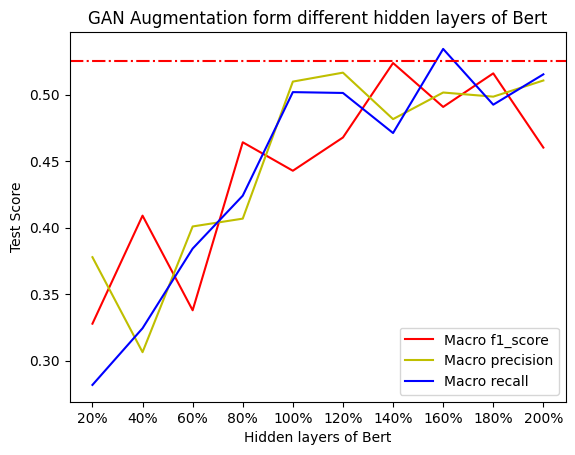

In [18]:
x_label=[str(i*20)+"%" for i in range(1,11)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(tbk_f1, label="Macro f1_score",color='r')
plt.plot(gan_f1, label="Macro precision",color='y')
plt.plot(hybrid_f1, label="Macro recall",color='b')
plt.axhline(y = 0.525, color = 'r', linestyle = 'dashdot')
plt.xticks([i for i in range(10)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()